In [1]:
import pickle
from collections import Counter
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context='poster')

In [2]:
with open('results/01_compare_baseline_models.pickle', 'rb') as f:
    svc_results, log_reg_results, random_forest_results, evaluated_datasets, baseline_times = pickle.load(f)
    
database = pd.read_json("database.json").T
database.loc[:, 'nrow'] = np.minimum(10000, database['nrow'])
    
with open('results/02_lightgbm_n_iter_25.pickle', 'rb') as f:
    lightgbm_25_results, lgb_25_times = pickle.load(f)
    
with open('results/03_autogluon_sec_300.pickle', 'rb') as f:
    autogluon_120s_results, autogluon_60s_times = pickle.load(f)

In [3]:
svc_df = pd.DataFrame(svc_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
svc_df['model'] = 'SVC'
log_reg_df = pd.DataFrame(log_reg_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
log_reg_df['model'] = 'Logistic Regression'

random_forest_df = pd.DataFrame(random_forest_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
random_forest_df['model'] = 'Random Forest'

lightgbm_25_df = pd.DataFrame(lightgbm_25_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
lightgbm_25_df['model'] = 'LightGBM (n_hyperparams=25)'

autogluon_300s_df = pd.DataFrame(autogluon_120s_results, columns=['auroc_fold_1', 'auroc_fold_2', 'auroc_fold_3', 'auroc_fold_4'], index=evaluated_datasets)
autogluon_300s_df['model'] = 'AutoGluon (sec=300)'

In [4]:
results_df = pd.concat([svc_df, log_reg_df, random_forest_df, lightgbm_25_df, autogluon_300s_df], axis=0)
results_df.columns = ['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4', 'model']
results_df = results_df.join(database, how='left')
results_df['mean_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].mean(1)
results_df['min_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].min(1)
results_df['max_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].max(1)
results_df['std_auroc'] = results_df[['auroc_split_1', 'auroc_split_2', 'auroc_split_3','auroc_split_4']].std(1)
results_df['dataset'] = results_df.index

In [5]:
# some datasets are not interesting because every algorithm does really well
# we exclude those to have clearer results
results_df = results_df.groupby('dataset').filter(lambda x: x['mean_auroc'].min() < 0.99)

In [6]:
# UCI++ has all kinds of dataset variants, and many of them have the same performance across the board
# removing those here as well
duped_datasets = [
    'wine-quality-white-5class', 'waveform-v2', 
    'volcanoes-a3', 'volcanoes-b3', 'volcanoes-b4', 
    'volcanoes-b5', 'volcanoes-b6', 'volcanoes-d3', 'volcanoes-d4',
    'statlog-german-credit-numeric', 'thyroid-allhyper', 'thyroid-allhypo',
    'thyroid-allrep', 'thyroid-hypothyroid', 'thyroid-dis'
]
results_df.drop(duped_datasets, inplace=True)
evaluated_datasets = set(results_df['dataset'])

In [7]:
# how often each model is best.
# anything within 0.5% of the best counts as "equally good" and gets full credit
winning_algorithms = []
for dataset in evaluated_datasets:
    df_sub = results_df.loc[dataset]
    highest_auroc = df_sub['mean_auroc'].max()
    winning_algorithms.extend(df_sub.loc[df_sub['mean_auroc'] >= highest_auroc * 0.995, 'model'])
print(f'Number of datasets each algorithm does best on (out of {len(evaluated_datasets)}):')
pprint(Counter(winning_algorithms))


# how often each model is worst.
# anything within 0.5% of the worst counts as "equally bad" and gets full credit
losing_algorithms = []
for dataset in evaluated_datasets:
    df_sub = results_df.loc[dataset]
    worst_auroc = df_sub['mean_auroc'].min()
    losing_algorithms.extend(df_sub.loc[df_sub['mean_auroc'] <= worst_auroc * 1.005, 'model'])
print(f'\nNumber of datasets each algorithm does worst on (out of {len(evaluated_datasets)}):')
pprint(Counter(losing_algorithms))
    
# some overall metrics for each model
print('\nAverage AUROC for each', results_df.groupby('model')['mean_auroc'].mean().sort_values(ascending=False), '\n')
print('Median AUROC for each', results_df.groupby('model')['mean_auroc'].median().sort_values(ascending=False))

Number of datasets each algorithm does best on (out of 108):
Counter({'AutoGluon (sec=300)': 74,
         'LightGBM (n_hyperparams=25)': 43,
         'Random Forest': 36,
         'Logistic Regression': 27,
         'SVC': 22})

Number of datasets each algorithm does worst on (out of 108):
Counter({'Logistic Regression': 56,
         'SVC': 47,
         'Random Forest': 26,
         'LightGBM (n_hyperparams=25)': 23,
         'AutoGluon (sec=300)': 13})

Average AUROC for each model
AutoGluon (sec=300)            0.885323
LightGBM (n_hyperparams=25)    0.872977
Random Forest                  0.869753
SVC                            0.840538
Logistic Regression            0.831857
Name: mean_auroc, dtype: float64 

Median AUROC for each model
AutoGluon (sec=300)            0.925830
LightGBM (n_hyperparams=25)    0.915428
Random Forest                  0.908864
SVC                            0.884252
Logistic Regression            0.882680
Name: mean_auroc, dtype: float64


In [8]:
# how often each one is best for the tiniest datasets
# anything within 0.5% of the best counts as a tie and gets full credit
flag = set(database[database.nrow < 250].index)

print('Average performance for each when nrow < 250', results_df[results_df.index.isin(flag)].groupby('model')['mean_auroc'].mean().sort_values(ascending=False), '\n')
print('Median performance for each when nrow < 250', results_df[results_df.index.isin(flag)].groupby('model')['mean_auroc'].median().sort_values(ascending=False))

Average performance for each when nrow < 250 model
AutoGluon (sec=300)            0.888861
Random Forest                  0.877026
LightGBM (n_hyperparams=25)    0.868754
SVC                            0.845580
Logistic Regression            0.831758
Name: mean_auroc, dtype: float64 

Median performance for each when nrow < 250 model
AutoGluon (sec=300)            0.918942
Random Forest                  0.908263
LightGBM (n_hyperparams=25)    0.896395
SVC                            0.868778
Logistic Regression            0.862797
Name: mean_auroc, dtype: float64


<AxesSubplot:xlabel='mean_auroc', ylabel='model'>

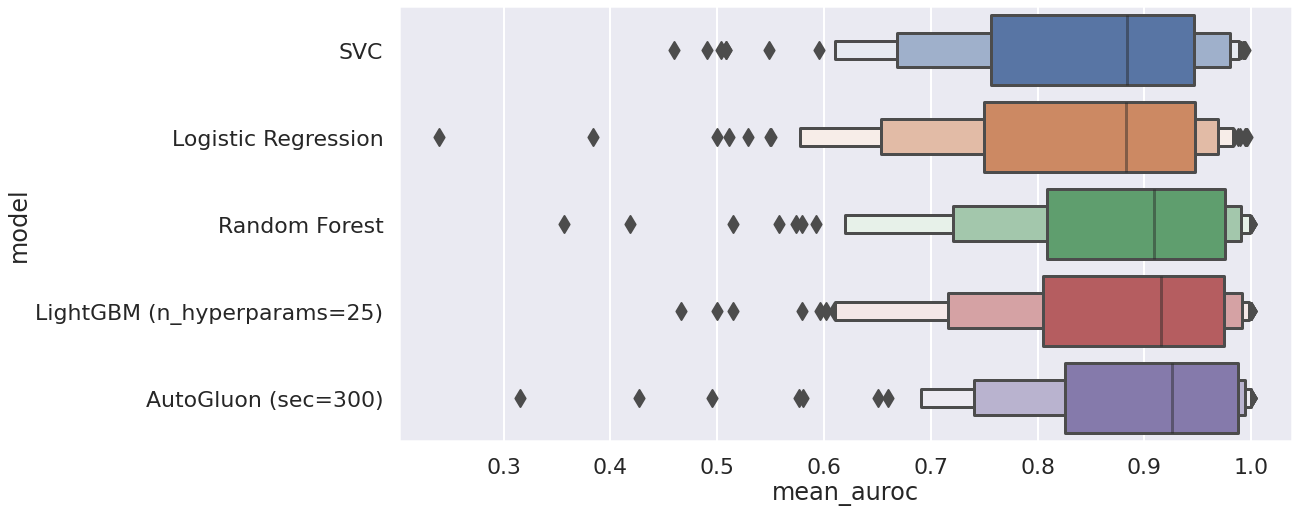

In [12]:
# distributions of each algorithm's mean aurocs
fig, ax = plt.subplots()
fig.set_size_inches(16, 8)
sns.boxenplot(data=results_df, x="mean_auroc", y='model', ax=ax)

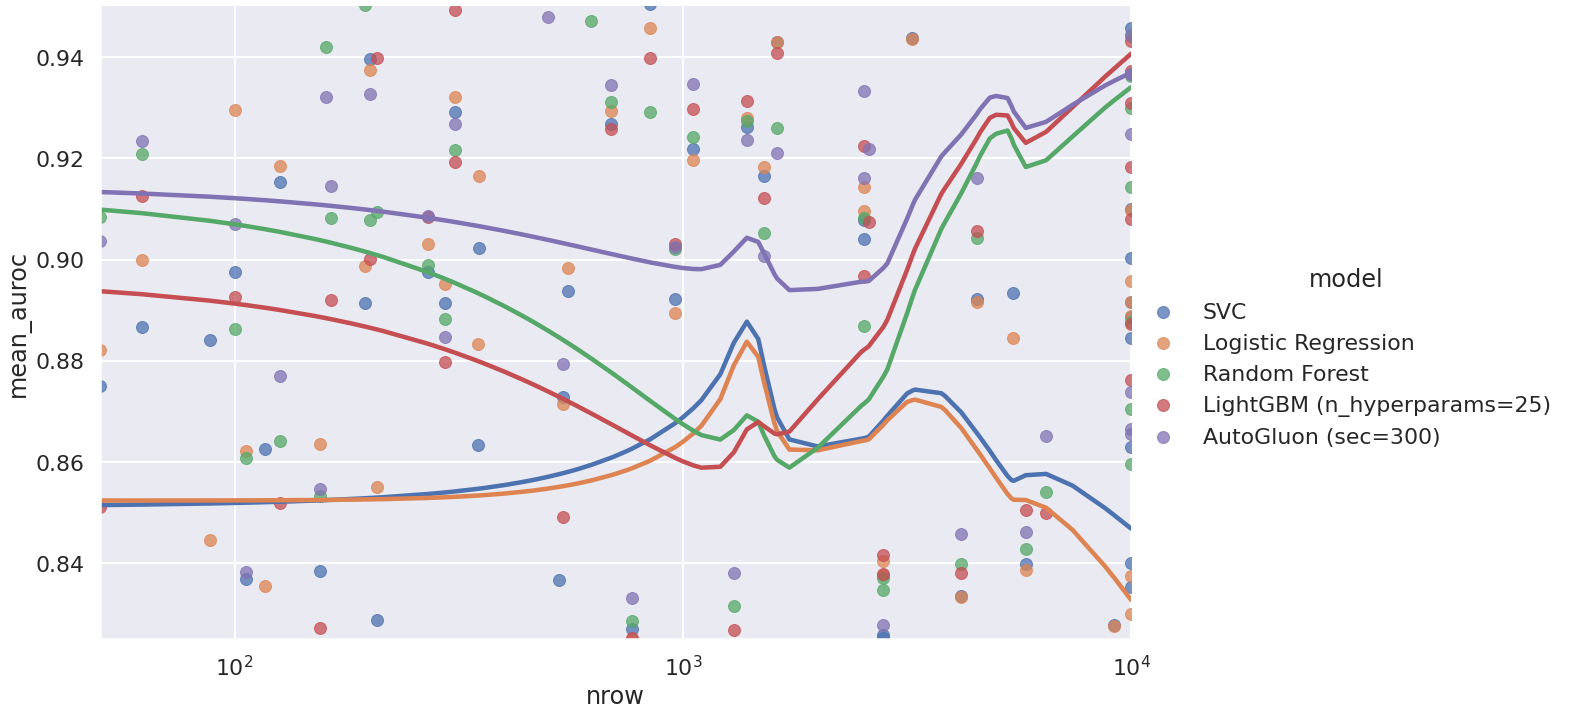

In [13]:
# mean auroc vs number of samples in the data
g = sns.lmplot(
    data=results_df,
    x="nrow", y="mean_auroc",
    hue="model",
    lowess=True,
    height=10,
    aspect=1.6,
    scatter_kws={'alpha': 0.75}
)
g.set(ylim=[0.825, 0.95])
g.set(xscale="log")

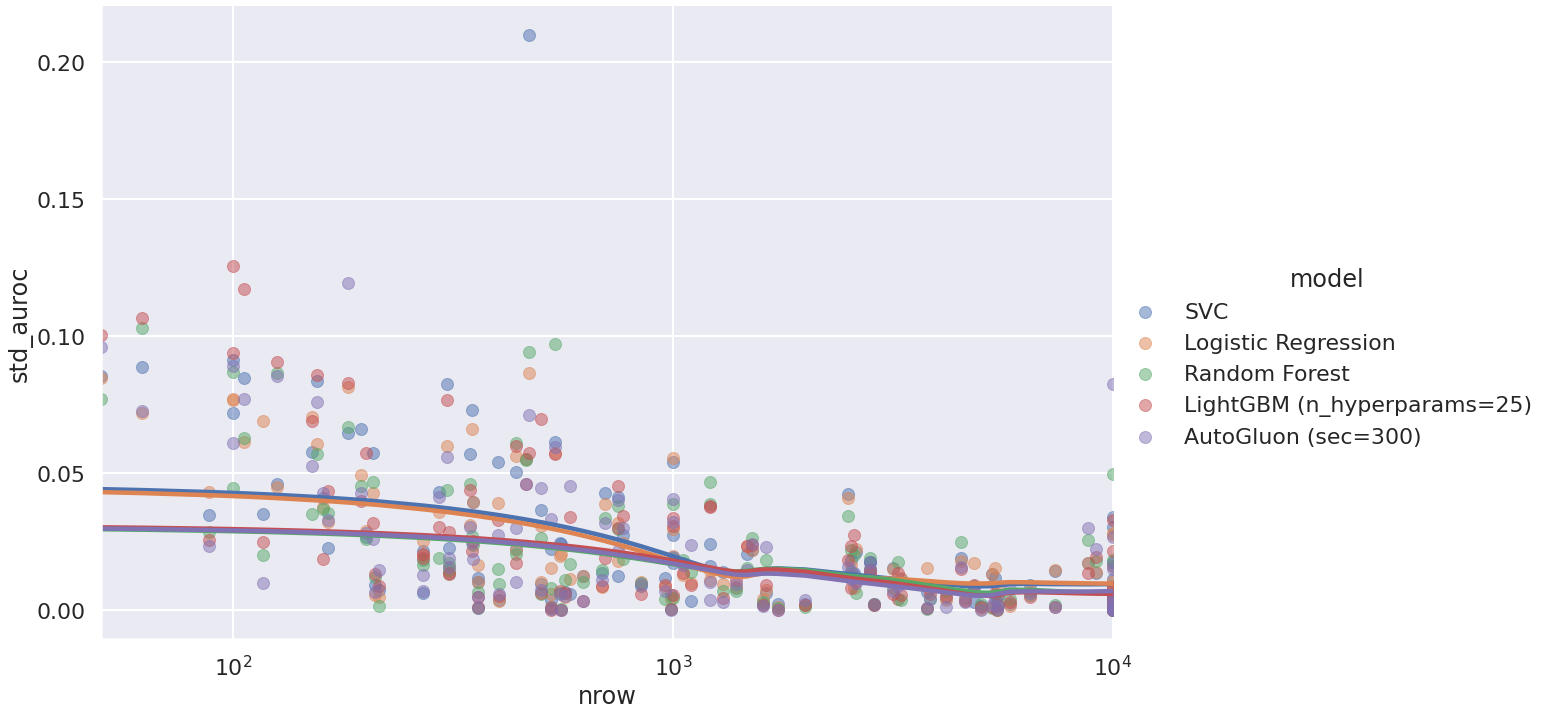

In [14]:
# standard deviation of auroc (across folds) vs number of samples in the data
g = sns.lmplot(
    data=results_df,
    x="nrow", y="std_auroc",
    hue="model",
    lowess=True,
    height=10, 
    aspect=1.6,
    scatter_kws={'alpha': 0.5}
)
g.set(xscale="log")

In [15]:
# datasets where there is a big gap between first largest and second largest performance
results_df.groupby('dataset')['mean_auroc'].apply(lambda x: np.sort(x)[-1] - np.sort(x)[-2]).sort_values()[-10:]

dataset
robot-failure-lp1                0.019089
indian-liver-patient             0.019648
teaching-assistant-evaluation    0.020016
leukemia-haslinger               0.022436
hayes-roth                       0.026846
connectionist-mines-vs-rocks     0.027492
habermans-survival               0.031654
wholesale-region                 0.035259
planning-relax                   0.129535
meta-data                        0.336665
Name: mean_auroc, dtype: float64